```{index} single: application; regression
```

# LAD Regression

Linear regression is a supervised machine learning technique that produces a linear model predicting values of a dependent variable from known values of one or more independent variables. Linear regression has a long history dating back to at least the 19th century and is a mainstay of modern data analysis. 

This notebook demonstrates a technique for linear regression based on LP that use the Least Absolute Deviation (LAD) as the metric to quantify the goodness of the model prediction. The sum of absolute values of errors is the $L_1$ norm which is known to have favorable robustness characteristics in practical use. We follow closely this [paper](https://www.jstor.org/stable/1402501).

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

## Generate data

The Python [scikit learn](https://scikit-learn.org/stable/) library for machine learning provides a full-featured collection of tools for regression. The following cell uses `make_regression` from scikit learn to generate a synthetic data set for use in subsequent cells. The data consists of a numpy array `y` containing `n_samples` of one dependent variable $y$, and an array `X` containing `n_samples` observations of `n_features` independent explanatory variables.

In [2]:
from sklearn.datasets import make_regression
import numpy as np

n_features = 1
n_samples = 1000
noise = 30

# generate regression dataset
np.random.seed(2020)
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise)

## Data Visualization

Before going further, it is generally useful to prepare an initial visualization of the data. The following cell presents a scatter plot of $y$ versus $x$ for the special case of one explanatory variable, and a histogram of the difference between $y$ and the mean value $\bar{y}$. This histogram will provide a reference against which to compare the residual error in $y$ after regression.

Text(0, 0.5, 'counts')

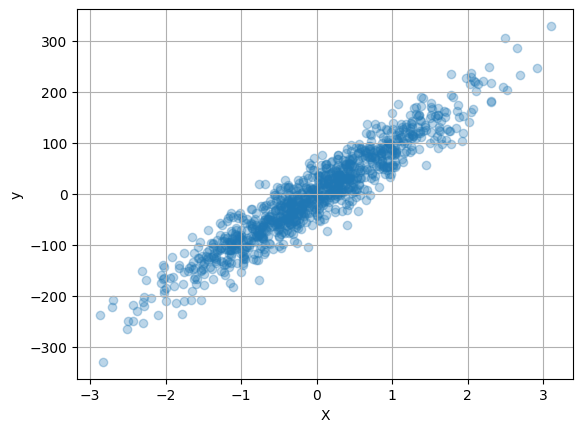

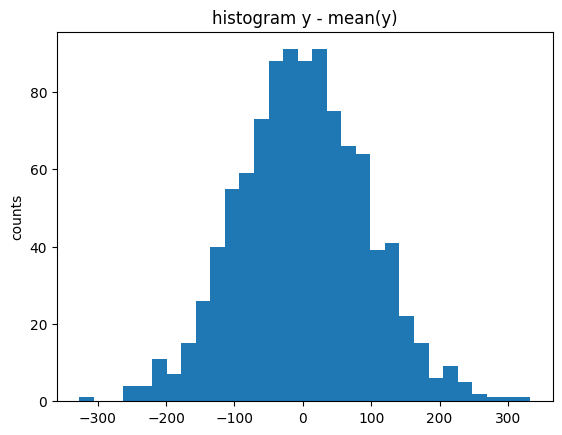

In [3]:
import matplotlib.pyplot as plt

if n_features == 1:
    plt.scatter(X, y, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.grid(True)
    
plt.figure()
plt.hist(y - np.mean(y), bins=int(np.sqrt(len(y))))
plt.title('histogram y - mean(y)')
plt.ylabel('counts')

## Model

Suppose we have a finite dataset consisting of $n$ points $\{({X}^{(i)}, y^{(i)})\}_{i=1,\dots,n}$ with ${X}^{(i)} \in \mathbb{R}^k$ and $y^{(i)} \in \mathbb{R}$. A linear regression model assumes the relationship between the vector of $k$ regressors ${X}$ and the dependent variable $y$ is linear. This relationship is modeled through an error or deviation term $e_i$, which quantifies how much each of the data points diverge from the model prediction and is defined as follows:

$$
\begin{equation}\label{eq:regression}
    e_i:= y^{(i)} - {m}^\top {X}^{(i)} - b = y^{(i)} - \sum_{j=1}^k X^{(i)}_j m_j - b,
\end{equation}
$$

for some real numbers $m_1,\dots,m_k$ and $b$.

The Least Absolute Deviation (LAD) is a possible statistical optimality criterion for such a linear regression. Similar to the well-known least-squares technique, it attempts to find a vector of linear coefficients ${m}=(m_1,\dots,m_k)$ and intercept $b$ so that the model closely approximates the given set of data. The method minimizes the sum of absolute errors, that is $\sum_{i=1}^n \left |e_i \right|$.

The LAD regression is formulated as an optimization problem with the intercept $b$, the coefficients $m_i$'s, and the errors $e_i$'s as decision variables, namely

$$
\begin{align}
    \min \quad & \sum_{i=1}^n |e_i| \\
    \text{s.t.} \quad & e_i = y^{(i)} - {m}^\top {X}^{(i)} - b & \forall\, i=1,\dots,n.
\end{align}
$$

In general, the appearance of an absolute value term indicates the problem is nonlinear and, worse, that the objective function is not differentiable when any $e_i = 0$. However, for this case where the objective is to minimize a sum of absolute errors, one can reformulate the decision variables to transform this into a linear problem. More specifically, introducing for every term $e_i$ two new variables $e_i^-, e_i^+ \geq 0$, we can rewrite the model as

$$
\begin{align}
    \min \quad & \sum_{i=1}^n ( e_i^+ + e_i^-) \\
    \text{s.t.} \quad & e_i^+ - e_i^- = y^{(i)} - {m}^\top {X}^{(i)}-b & \forall\, i=1, \dots, n \\
    & e_i^+, e_i^- \geq 0 & \forall\, i=1, \dots, n
\end{align}
$$

The following cell provides a direct implementation of LAD regression.

In [4]:
import pyomo.environ as pyo

def lad_regression(X, y):

    m = pyo.ConcreteModel('LAD Regression')

    n, k = X.shape

    # note use of Python style zero based indexing 
    m.I = pyo.RangeSet(0, n-1)
    m.J = pyo.RangeSet(0, k-1)

    m.ep = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.em = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.m = pyo.Var(m.J)
    m.b = pyo.Var()

    @m.Constraint(m.I)
    def residuals(m, i):
        return m.ep[i] - m.em[i] == y[i] - sum(X[i][j]*m.m[j] for j in m.J) - m.b

    @m.Objective(sense=pyo.minimize)
    def sum_of_abs_errors(m):
        return sum(m.ep[i] + m.em[i] for i in m.I)

    pyo.SolverFactory('cbc').solve(m)
    
    return m

m = lad_regression(X, y)
m.m.display()
m.b.display()

m : Size=1, Index=J
    Key : Lower : Value     : Upper : Fixed : Stale : Domain
      0 :  None : 90.481974 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value       : Upper : Fixed : Stale : Domain
    None :  None : -0.18784712 :  None : False : False :  Reals


## Visualizing the Results

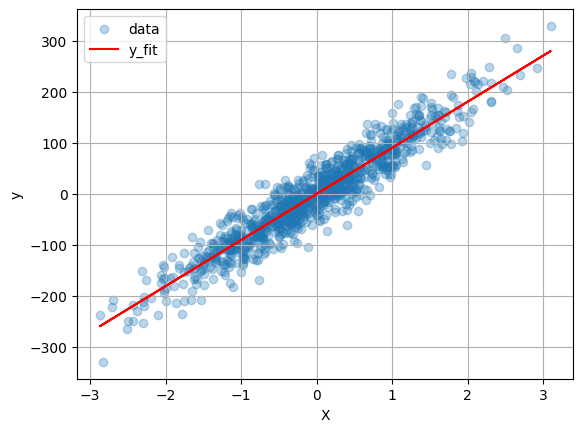

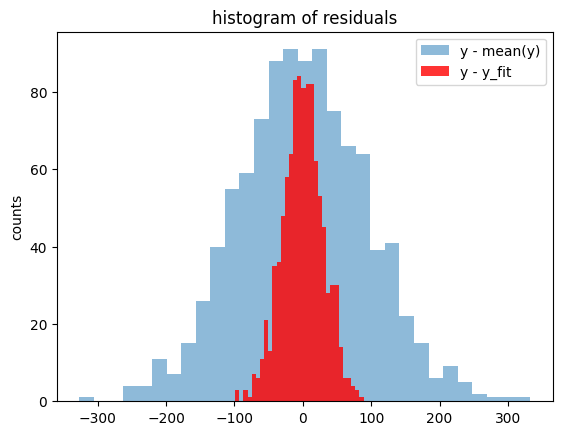

In [5]:
y_fit = np.array([sum(x[j]*m.m[j]() for j in m.J) + m.b() for x in X])

if n_features == 1:
    plt.scatter(X, y, alpha=0.3, label="data")
    plt.plot(X, y_fit, 'r', label="y_fit")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    
plt.figure()
plt.hist(y - np.mean(y), bins=int(np.sqrt(len(y))), alpha=0.5, label="y - mean(y)")
plt.hist(y - y_fit, bins=int(np.sqrt(len(y))), color='r', alpha=0.8, label="y - y_fit")
plt.title('histogram of residuals')
plt.ylabel('counts')
plt.legend()